In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 96.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import os, sys, importlib
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from time import time as clock
from tqdm.notebook import tqdm

In [5]:
DRIVE_ROOT = "/content/drive/MyDrive/DynamicsTensors"
REPO_ROOT  = f"{DRIVE_ROOT}/bstt2"
DATA_DIR   = f"{DRIVE_ROOT}/data"
OUT_DIR    = f"{DRIVE_ROOT}/outputs"

EXP = "basetests"
RUN_DIR = f"{OUT_DIR}/{EXP}"

os.makedirs(RUN_DIR, exist_ok=True)
if REPO_ROOT not in sys.path: sys.path.append(REPO_ROOT)

print("Repo:", REPO_ROOT)
print("Data:", DATA_DIR)
print("Run dir:", RUN_DIR)
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")

from utils import name_scan, inspect_fields, load_fields, Dataset, chartostring, plot_flow_snapshot, plot_heatmap_contours

Repo: /content/drive/MyDrive/DynamicsTensors/bstt2
Data: /content/drive/MyDrive/DynamicsTensors/data
Run dir: /content/drive/MyDrive/DynamicsTensors/outputs/basetests


In [6]:
# Uploading original bsst modules
from misc import  __block, sinecosine_measures,monomial_measures, random_homogenous_polynomial_sum_system2,random_fixed_variable_sum_system2,legendre_measures
from helpers import fermi_pasta_ulam,fermi_pasta_ulam2,SMat
from als import ALSSystem2
from bstt import Block, BlockSparseTensor, BlockSparseTT
block = __block()

In [7]:
for path in [train_path, test_path]:
    print("\n=== File:", os.path.basename(path), "===\n")
    ds = Dataset(path, "r")

    # Basic dims and time
    num_dim   = ds.dimensions.get("num_dim").size        if "num_dim"   in ds.dimensions else None
    num_nodes = ds.dimensions.get("num_nodes").size      if "num_nodes" in ds.dimensions else None
    num_elem  = ds.dimensions.get("num_elem").size       if "num_elem"  in ds.dimensions else None
    n_steps   = ds.dimensions.get("time_step").size      if "time_step" in ds.dimensions else 0
    print(f"num_dim={num_dim}, num_nodes={num_nodes}, num_elem={num_elem}, time_steps={n_steps}")

    # Time
    if "time_whole" in ds.variables:
        times = ds.variables["time_whole"][:]
        print(f"time_whole: shape={times.shape} example={times[:3]}")

    if "name_nod_var" in ds.variables:
        names = chartostring(ds.variables["name_nod_var"][:]).tolist()
        names = [s.strip() for s in names]
        print("nodal var names:", names)
    else:
        print("nodal var names: (none declared)")

    keys = sorted(ds.variables.keys())
    print("\nvariable keys (subset):", keys[:15], "..." if len(keys)>15 else "")

    nod_keys = [k for k in keys if k.startswith("vals_nod_var")]
    if nod_keys:
        k0 = nod_keys[0]
        print(f"\nExample nodal values: ds.variables['{k0}'][:] -> shape", ds.variables[k0].shape,
              "(expected (time_step, num_nodes))")

    for ckey in ["coordx","coordy","coordz"]:
        if ckey in ds.variables:
            print(f"{ckey}: shape", ds.variables[ckey].shape)

    conn_keys = [k for k in keys if k.startswith("connect")]
    if conn_keys:
        print("connectivity keys:", conn_keys[:5])

    ds.close()

print("\n# Extraction patterns :")
print("times      = ds.variables['time_whole'][:]                 # (time_step,)")
print("xcoord     = ds.variables.get('coordx')[:]                  # (num_nodes,) if present")
print("ycoord     = ds.variables.get('coordy')[:]                  # (num_nodes,) if present")
print("u_time     = ds.variables['vals_nod_var1'][:]               # (time_step, num_nodes) for 1st nodal var")
print("# map index→name: chartostring(ds.variables['name_nod_var'][:]).tolist()")



=== File: train_data.e ===

num_dim=2, num_nodes=6569, num_elem=6384, time_steps=5541
time_whole: shape=(5541,) example=[0. 1. 2.]
nodal var names: ['V_y', 'V_x', 'P']

variable keys (subset): ['connect1', 'coor_names', 'coordx', 'coordy', 'eb_names', 'eb_prop1', 'eb_status', 'elem_num_map', 'elem_ss1', 'elem_ss2', 'elem_ss3', 'elem_ss4', 'name_nod_var', 'node_num_map', 'qa_records'] ...

Example nodal values: ds.variables['vals_nod_var1'][:] -> shape (5541, 6569) (expected (time_step, num_nodes))
coordx: shape (6569,)
coordy: shape (6569,)
connectivity keys: ['connect1']

=== File: test_data_2.e ===

num_dim=2, num_nodes=6569, num_elem=6384, time_steps=1409
time_whole: shape=(1409,) example=[0. 1. 2.]
nodal var names: ['V_y', 'V_x', 'P']

variable keys (subset): ['connect1', 'coor_names', 'coordx', 'coordy', 'eb_names', 'eb_prop1', 'eb_status', 'elem_num_map', 'elem_ss1', 'elem_ss2', 'elem_ss3', 'elem_ss4', 'name_nod_var', 'node_num_map', 'qa_records'] ...

Example nodal values: ds.v

In [8]:
train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")
print("format:", name_scan(train_path))
###################################################
meta = inspect_fields(train_path)
print(meta)
times, coordx, coordy, Vx, Vy, P, V_stack = load_fields(train_path, t_start=0, t_count=None)
print("shape times:", times.shape)
print("shape coords:", coordx.shape, coordy.shape)
print("shape Vx/Vy/P:", Vx.shape, Vy.shape, P.shape)
print("shape V_stack:", V_stack.shape)

format: exodus
{'format': 'exodus', 'num_nodes': 6569, 'num_elems': 6384, 'time_steps': 5541, 'nodal_var_names': ['V_y', 'V_x', 'P'], 'time_key_guess': 'time_whole'}
shape times: (5541,)
shape coords: (6569,) (6569,)
shape Vx/Vy/P: (6569, 5541) (6569, 5541) (6569, 5541)
shape V_stack: (13138, 5541)


## Some old plots to see how data looks like

In [9]:
#plot_flow_snapshot(train_path, t_index = 44, quiver_frac=0.2)

In [9]:
#plot_heatmap_contours(train_path, t_index=2588, field="speed",    levels=100)

In [10]:
#Pressure heat map:
#plot_heatmap_contours(train_path, t_index=3300, field="pressure", levels=100)

### DS assembly and Plotting

In [10]:
# test set:
times, x, y, Vx, Vy, P, V = load_fields(train_path, t_start=0, t_count=5541)
print(times.shape, Vx.shape, Vy.shape, P.shape, V.shape)
#############################
DT = 1385 # one experiemnt per Re number! This Corresponds to RE = 300
DT_TEST = 250

# tr_idx_cut_low = 0 * DT + 1
# tr_idx_cut_high = 1 * DT  -1 - DT_TEST

# # RE = 400 ?
tr_idx_cut_low = 4034 + 1
tr_idx_cut_high = 4034 + 1385  -1 - DT_TEST

# RE = 100 ?
# tr_idx_cut_low = 0
# tr_idx_cut_high = 1219 - DT_TEST

# # RE = 300 ?
# tr_idx_cut_low = 1222
# tr_idx_cut_high = 2588 - DT_TEST

times_test = times[tr_idx_cut_high:tr_idx_cut_high + DT_TEST] # time array is uniform,  but there are just indices (not real time)
Vx_test = Vx[:,tr_idx_cut_high:tr_idx_cut_high + DT_TEST]
Vy_test = Vy[:,tr_idx_cut_high:tr_idx_cut_high + DT_TEST]
V_test = V[:,tr_idx_cut_high:tr_idx_cut_high + DT_TEST]
############################
times = times[tr_idx_cut_low:tr_idx_cut_high]
Vx = Vx[:,tr_idx_cut_low:tr_idx_cut_high]
Vy = Vy[:,tr_idx_cut_low:tr_idx_cut_high]
V = V[:,tr_idx_cut_low:tr_idx_cut_high]
###########################
X =V[:,0:V.shape[1]-1]
Xprime = V[:,1:V.shape[1]]
assert X.shape == Xprime.shape


(5541,) (6569, 5541) (6569, 5541) (6569, 5541) (13138, 5541)


In [11]:
times_t, x_t, y_t, Vx_t, Vy_t, P_t, V_t = load_fields(test_path, t_start=0, t_count=5541)
print(times_t.shape, Vx_t.shape, Vy_t.shape, P_t.shape, V_t.shape)

(1409,) (6569, 1409) (6569, 1409) (6569, 1409) (13138, 1409)


In [12]:
### similarity matrix:
Vav = V - np.mean(V,axis = 1, keepdims=True) # shape [n, M]
sim_V = Vav.T @ Vav # shape [M,M] - this is small matrix!
UC,SC,VC = np.linalg.svd(sim_V, full_matrices=False) # one can esitmate eigenvalues and linear dimension.
cut_off_ind = 20
VC = VC[:,:cut_off_ind]
VC.shape

(1133, 20)

Spectral Energy: 99.36074471392614 % of 20


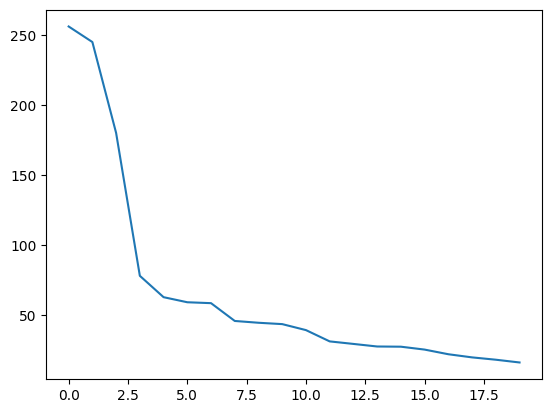

In [13]:
s = np.sqrt(SC)
sr = s[0:cut_off_ind]
plt.plot(sr)
print(f'Spectral Energy: {100 * np.sum(sr**2)/np.sum(s**2)} % of {cut_off_ind}')

In [15]:
def load_triangulation(path):
    """
    Return matplotlib.tri.Triangulation for the first connectivity present.
    Supports triangles or quads (quads are split into two triangles).
    """
    ds = Dataset(path, "r")
    x = np.asarray(ds.variables["coordx"][:])
    y = np.asarray(ds.variables["coordy"][:])

    conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
    assert conn_keys, "No connectivity array ('connect*') found in file."
    conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1

    if conn.shape[1] == 3:
        tri_conn = conn
    elif conn.shape[1] == 4:
        tri_conn = np.vstack([conn[:, [0, 1, 2]],
                              conn[:, [0, 2, 3]]])
    else:
        ds.close()
        raise ValueError(f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4).")

    tri = mtri.Triangulation(x, y, triangles=tri_conn)
    ds.close()
    return tri

In [16]:
def compute_POD(X_full, r, demean=False, simplified = True):
    """
    POD via SVD for stacked velocity fields.
    X_full: (2*N_nodes, m) with rows stacked as [Vx; Vy], columns = snapshots
    r     : target rank (capped to <= min(n, m))
    demean: subtract temporal mean per state component if True

    Returns:
        Ur   : (2*N_nodes, r) spatial POD modes (columns)
        s_r  : (r,) singular values
        A    : (r, m) temporal coefficients (a_j(t) = s_j * V_j(t))
        mu   : (2*N_nodes,) training mean (zeros if demean=False)
    """
    X = np.asarray(X_full)
    n, m = X.shape
    if demean:
        mu = X.mean(axis=1)  # [n,]
        Xc = X - mu[:, None] # [n,M]
    else:
        mu = np.zeros(n)
        Xc = X

    r = int(max(1, min(r, min(n, m))))
    if simplified:
        # caluclate siilarity matrix:
        sim_data = Xc.T @ Xc # shape [M,M] - this is small matrix!
        UC,SC,VC = np.linalg.svd(sim_data, full_matrices=False) # one can esitmate eigenvalues and linear dimension.
        sr   = np.sqrt(SC[:r]) # shape [r,]
        Vr = VC[:r,:].T # shape [M,r] temporal modes
        Ur = X @ Vr @ np.diag(1.0/sr) # shape [n,r] # spatial POD Modes
        A   = (sr[:, None] * Vr.T)   # temporal coeffs
    else:
        U, s, VT = np.linalg.svd(Xc, full_matrices=False)  # standard SVD X = U s V^T
        Ur   = U[:, :r]                      # shape [n, r]
        sr   = s[:r]                         # shape [r,]
        Vr   = VT[:r, :].T                   # shape [M, r]  (this is Vr) as above
        A   = (sr[:, None] * Vr.T)   # temporal coeffs

    return Ur, sr, A, mu


def pod_plot_modes_simple(Ur, s_r, A, tri, time_arr, modes=(0,1,2),
                          layout="stacked", quiver_frac=0.03, cmap=None,
                          time_unit="s"):
    """
    Simple POD mode plotter for unstructured meshes (Triangulation).
    Shows, per selected mode j:
      - left: |φ_j| heatmap with quiver of (u_j, v_j)
      - right: temporal coefficient a_j(t)

    Args:
        Ur        : (2*N_nodes, r) spatial modes (from compute_POD)
        s_r       : (r,) singular values
        A         : (r, m) temporal coefficients
        tri       : matplotlib.tri.Triangulation (your mesh)
        time_arr  : (m,) time stamps (units given by time_unit)
        modes     : iterable of mode indices to plot
        layout    : "stacked" or "interleaved"
        quiver_frac : fraction of nodes to draw arrows (e.g., 0.03 → 3%)
        cmap      : optional colormap
        time_unit : label for time axis ("s", "ms", "Δt", etc.)

    Returns:
        fig : matplotlib Figure
    """
    t = np.asarray(time_arr, dtype=float)
    assert t.ndim == 1 and t.size == A.shape[1], "time_arr must be 1-D with length = A.shape[1]"
    n_nodes = tri.x.size

    nrows = len(modes)
    fig, axes = plt.subplots(nrows, 2, figsize=(11, 3.2*nrows))
    if nrows == 1:
        axes = np.array([axes])

    # quiver subsampling
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n_nodes, step)

    total_energy = float(np.sum(s_r**2)) if s_r.size else 0.0

    for row, j in enumerate(modes):
        # ----- spatial mode -----
        ax_f = axes[row, 0]
        phi_j = Ur[:, j]

        if layout == "stacked":
            assert phi_j.size == 2*n_nodes, "Ur must be stacked [Vx; Vy]"
            u = phi_j[:n_nodes].real
            v = phi_j[n_nodes:].real
        elif layout == "interleaved":
            assert phi_j.size == 2*n_nodes, "Ur length must be 2*N_nodes"
            uv = phi_j.reshape(n_nodes, 2).real
            u, v = uv[:, 0], uv[:, 1]
        else:
            raise ValueError("layout must be 'stacked' or 'interleaved'")

        mag = np.hypot(u, v)
        im = ax_f.tripcolor(tri, mag, shading="gouraud", cmap=cmap)
        ax_f.quiver(tri.x[q_idx], tri.y[q_idx], u[q_idx], v[q_idx],
                    angles="xy", scale_units="xy", scale=1, width=0.002, alpha=0.9)
        ax_f.set_aspect("equal", adjustable="box")
        ax_f.set_xticks([]); ax_f.set_yticks([])

        energy_frac = (s_r[j]**2) / total_energy if total_energy > 0 else 0.0
        ax_f.set_title(f"POD mode {j} — |φ|  (energy {energy_frac*100:.1f}%)")
        cb = plt.colorbar(im, ax=ax_f, fraction=0.046, pad=0.04)
        cb.set_label("|φ|")

        # ----- temporal coefficient -----
        ax_t = axes[row, 1]
        a_t = A[j, :].real
        ax_t.plot(t, a_t, lw=1.8)
        ax_t.set_xlabel(f"time [{time_unit}]")
        ax_t.set_ylabel("a_j(t)")
        ax_t.set_title(f"POD mode {j} — temporal coefficient")

    fig.suptitle("POD modes & time dynamics (simple)", y=0.995, fontsize=12)
    fig.tight_layout()
    return fig


def plot_vector_field(
    Fx,
    Fy,
    x,
    y,
    path,
    name,
    t_index=0,
    quiver_frac=0.03,
    probe_node=None,
    use_file_connectivity=True,
):
    """
    Plot a 2D vector field on an unstructured mesh.

    Parameters
    ----------
    Fx, Fy : (N_nodes, T)
        Components of the field (e.g. Vx, Vy) on nodes over time.
    x, y   : (N_nodes,)
        Node coordinates. Can be full or coarse-grained.
    path   : str
        Path to Exodus-II file (used to read connectivity if possible).
    t_index : int
        Time index to plot.
    quiver_frac : float
        Approximate fraction of nodes to use for quiver arrows (e.g. 0.03 -> ~3%).
    probe_node : int or None
        If not None, highlight this node index.
    use_file_connectivity : bool
        If True, try to use Exodus connectivity; if it doesn't match x,y size,
        fall back to Delaunay triangulation.
    """

    Fx = np.asarray(Fx)
    Fy = np.asarray(Fy)
    x = np.asarray(x)
    y = np.asarray(y)

    assert Fx.shape == Fy.shape, "Fx and Fy must have same shape (N_nodes, T)"
    assert x.shape == y.shape, "x and y must have same shape (N_nodes,)"

    N_nodes, T = Fx.shape
    assert 0 <= t_index < T, f"t_index={t_index} out of range [0, {T-1}]"

    # --- Build triangulation ---
    tri = None
    if use_file_connectivity:
        try:
            ds = Dataset(path, "r")
            conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
            if not conn_keys:
                raise RuntimeError("No connectivity array ('connect*') found in file.")
            conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1

            # handle tri/quad elements
            if conn.shape[1] == 3:
                conn_full = conn
            elif conn.shape[1] == 4:
                conn_full = np.vstack([
                    conn[:, [0, 1, 2]],
                    conn[:, [0, 2, 3]],
                ])
            else:
                raise RuntimeError(
                    f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4)"
                )

            # if connectivity refers to indices >= N_nodes, we can't use it with current x,y
            if conn_full.max() >= N_nodes:
                # we already coarse-grained, so use Delaunay instead
                raise RuntimeError("Connectivity index exceeds x,y size; using Delaunay.")

            tri = mtri.Triangulation(x, y, triangles=conn_full)
        except Exception as e:
            # Fallback: Delaunay triangulation from x,y only
            # (fine for visualization, not for exact FEM topology)
            # print(f"Falling back to Delaunay triangulation: {e}")
            tri = mtri.Triangulation(x, y)
    else:
        tri = mtri.Triangulation(x, y)

    # --- Snapshot ---
    Vx_t = Fx[:, t_index]
    Vy_t = Fy[:, t_index]
    magnitude = np.sqrt(Vx_t**2 + Vy_t**2)

    # --- Downsample quiver points ---
    n = x.size
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n, step)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(15, 10))

    # scalar field |F|
    tpc = ax.tripcolor(tri, magnitude, shading="gouraud")
    plt.colorbar(tpc, ax=ax, shrink=0.9, label="|F|")

    # vector field
    ax.quiver(
        x[q_idx], y[q_idx], Vx_t[q_idx], Vy_t[q_idx],
        angles="xy", scale_units="xy", scale=1, width=0.002,
        alpha=0.9, zorder=3
    )

    # optional probe highlight
    if probe_node is not None and 0 <= probe_node < N_nodes:
        ax.scatter(x[probe_node], y[probe_node],
                   c="red", s=60, zorder=4, label=f"node {probe_node}")
        ax.legend(loc="best")

    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{name} | t={t_index}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.tight_layout()
    plt.show()



In [17]:

Ur, s_r, A, mu = compute_POD(V, r=25, demean=True, simplified = False)

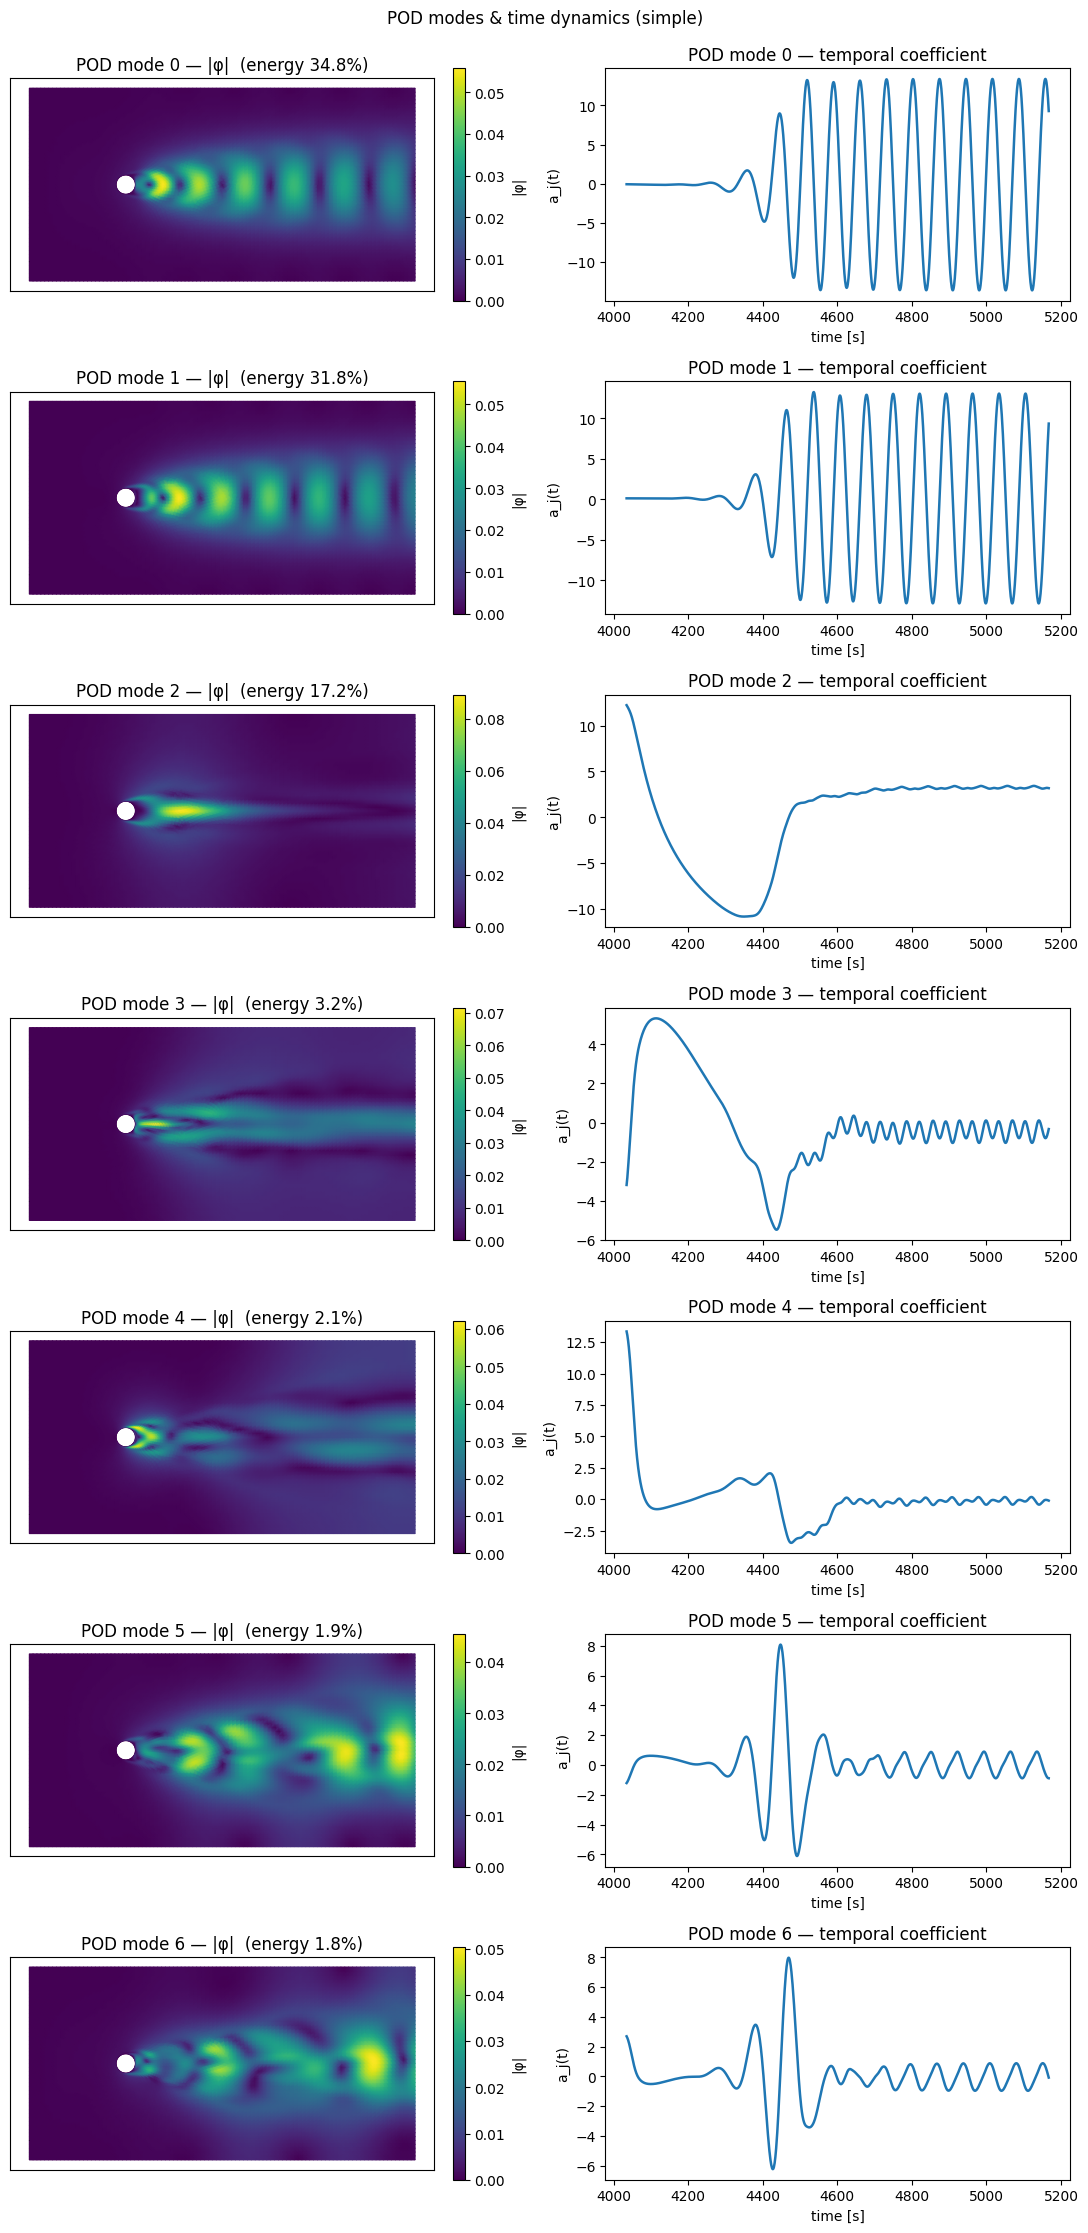

In [18]:
tri = load_triangulation(train_path)
fig = pod_plot_modes_simple(Ur, s_r, A, tri, times,modes=(0,1,2,3,4,5,6),
                            layout="stacked", quiver_frac=0)
plt.show()

In [19]:
V_test.shape

(13138, 250)

In [20]:
# PCA lead projection
print(f'PCA linear map shape: {Ur.shape}')
# Principal ROM mapping. Demeaned
Xr = Ur.T @ V
Xr_test = Ur.T @ V_test
#############################################
Xrav = Xr - np.mean(Xr,axis = 1, keepdims=True) # shape [r, M] # Train
Xrav_test = Xr_test - np.mean(Xr,axis = 1, keepdims=True) # shape [r, M_test] # Test
#Xrav_test = Xr_test
print(f'PCA projected data shape: {Xrav.shape}')
print(f'PCA projected test data shape: {Xrav_test.shape}')
##############################################

PCA linear map shape: (13138, 25)
PCA projected data shape: (25, 1133)
PCA projected test data shape: (25, 250)


In [21]:
V_test.shape

(13138, 250)

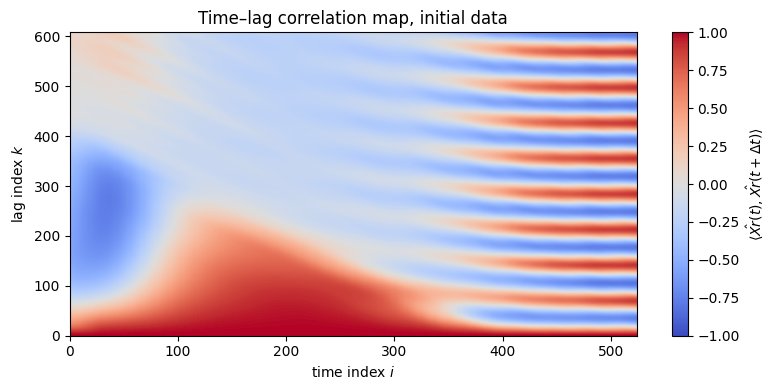

In [23]:
Xrav_normalized = Xrav / np.linalg.norm(Xrav, axis=0)
#Xrav_normalized = Xrav/np.max(Xrav, axis = 1)[:, None]
Simr = Xrav_normalized.T @ Xrav_normalized

# Simr: (M, M) where M is time measuremnts
T = Simr.shape[0]

# choose max lag you care about (in indices)
max_lag = 608  # for example, must be < T

# base times i = 0,...,T-max_lag-1
base_idx = np.arange(T - max_lag)
lags = np.arange(max_lag + 1)

# C[k, i] = Simr[i, i + k]
C = np.empty((max_lag + 1, T - max_lag))
for k in range(max_lag + 1):
    i = base_idx
    j = base_idx + k
    C[k, :] = Simr[i, j]

plt.figure(figsize=(8, 4))
im = plt.imshow(
    C,
    origin='lower',
    aspect='auto',
    interpolation='nearest',
    extent=[base_idx[0], base_idx[-1], lags[0], lags[-1]],
    vmin=-1, vmax=1,            # cosine similarity range
    cmap='coolwarm'
)
plt.colorbar(im, label=r'$\langle \hat{Xr}(t), \hat{Xr}(t+\Delta t)\rangle$')
plt.xlabel('time index $i$')
plt.ylabel('lag index $k$')
plt.title('Time–lag correlation map, initial data')
plt.tight_layout()
plt.show()
# We might expect transient effect with strong linear dependencies of different modes. Thease are vortices ( I assume)

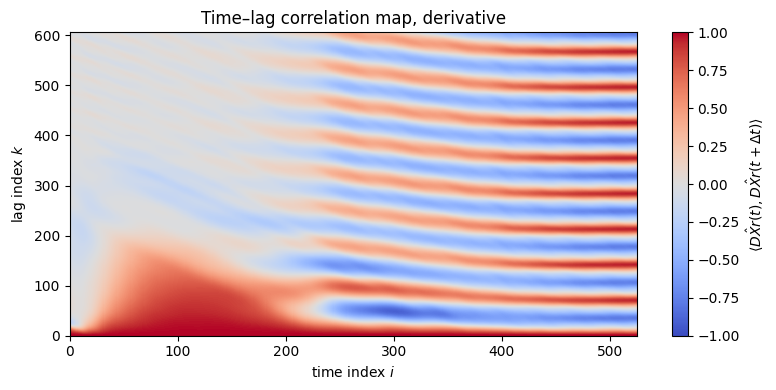

In [24]:
DXrav = Xrav[:,1:] - Xrav[:,:-1]
DXrav_normalized = DXrav / np.linalg.norm(DXrav, axis=0)
#DXrav_normalized = DXrav/np.max(DXrav, axis = 1)[:, None]
# Dynaical modes similarities ( correlation Length in time)
SimDr = DXrav_normalized.T @ DXrav_normalized

# Simr: (M, M) where M is time measuremnts
T = SimDr.shape[0]

# choose max lag you care about (in indices)
max_lag = 606  # for example, must be < T

# base times i = 0,...,T-max_lag-1
base_idx = np.arange(T - max_lag)
lags = np.arange(max_lag + 1)

# C[k, i] = Simr[i, i + k]
C = np.empty((max_lag + 1, T - max_lag))
for k in range(max_lag + 1):
    i = base_idx
    j = base_idx + k
    C[k, :] = SimDr[i, j]

plt.figure(figsize=(8, 4))
im = plt.imshow(
    C,
    origin='lower',
    aspect='auto',
    interpolation='nearest',
    extent=[base_idx[0], base_idx[-1], lags[0], lags[-1]],
    vmin=-1, vmax=1,            # cosine similarity range
    cmap='coolwarm'
)
plt.colorbar(im, label=r'$\langle \hat{DXr}(t), \hat{DXr}(t+\Delta t)\rangle$')
plt.xlabel('time index $i$')
plt.ylabel('lag index $k$')
plt.title('Time–lag correlation map, derivative')
plt.tight_layout()
plt.show()

In [25]:
Xrav.shape

(25, 1133)

In [26]:
# Implimentaiton of Legandre Dict up to degree 3:
# CONFIGURATION:
order =  25
degree = 3  # [p0,p1,p2,p3...] - degree of funciton from dictionary
maxGroupSize = 6
interaction = 17
#interaction = [2]*order
trainSampleSize = [1132]
maxSweeps = 100
ranks = [2]*(order-1)
targetResidual = 1e-6
testSampleSize = 250
seed_global = 123
###############################################################################

In [27]:
def build_measures(points, degree):
    """
    Build Legendre dict values per coordinate and optionally append a constant mode.
    points: (N, order)
    Returns:
        measures: (order + add_constant, N, degree+1)
    """
    #measures = legendre_measures(points, degree)
    measures = monomial_measures(points, degree)
    #measures = sinecosine_measures(points)
    return measures


def build_model(order, degree, maxGroupSize, interaction, selection_matrix=None):
    """
    Create a BlockSparseTTSystem2 model with degree-banded blocks and interaction gating.
    System2 expects an integer selection matrix of shape (D, order) where
    D = number of equations (=order here) and 'order' is the number of TT cores
    (we use order+1 measures; the extra constant mode is handled by the TT builder)
    """
    S = selection_matrix if selection_matrix is not None else SMat(interaction, order)
    bstt = random_homogenous_polynomial_sum_system2(
        _univariateDegrees=[degree] * order,
        _totalDegree=degree,
        _maxGroupSize=maxGroupSize,
        _numberOfInteractions=interaction,
        _selectionMatrix=S,
    )
    return bstt


def fit_model(bstt, measures, targets, maxSweeps, targetResidual, maxGroupSize, verbosity=1):
    """
    Wrap ALSSystem2 with already-augmented measures.
    measures: (order+1, N_samples, degree+1)
    targets:  (N_samples, order)
    """
    solver = ALSSystem2(bstt, measures, targets, _verbosity=verbosity)
    solver.maxSweeps = maxSweeps
    solver.targetResidual = targetResidual
    solver.maxGroupSize = maxGroupSize

    solver.run()
    return bstt, solver
# Evaluation
def rel_L2(pred, truth):
    """Relative L2 error"""
    return np.linalg.norm(pred - truth) / np.linalg.norm(truth)
def evaluate_model(bstt, measures_train, y_train, measures_test, y_test):
    """
    Evaluate on train & test measures/targets.
    Returns (err_train, err_test)
    """
    ytr_hat = bstt.evaluate(measures_train)
    yte_hat = bstt.evaluate(measures_test)
    return rel_L2(ytr_hat, y_train), rel_L2(yte_hat, y_test)

def run_learning_curve(
    states_full,    # (N_total, order) = points
    derivs_full,    # (N_total, order) = values
    states_test,    # (N_test_total, order)
    derivs_test,    # (N_test_total, order)
    order,
    degree,
    maxGroupSize,
    interaction,
    trainSampleSizes,
    testSampleSize,
    maxSweeps,
    targetResidual,
    seed=123,
    verbose=1,
):
    results = []

    # select test set
    N_test = min(testSampleSize, states_test.shape[0])
    test_points  = states_test[:N_test, :]
    test_values  = derivs_test[:N_test, :]

    test_measures = build_measures(test_points, degree)   # (order, N_test, degree+1)
    augmented_test_measures = np.concatenate([test_measures, np.ones((1,N_test,degree+1))], axis=0)


    for N_samples_train in trainSampleSizes:
        if verbose:
            print(f"\n=== Training with N={N_samples_train} samples ===")

        train_points = states_full[:N_samples_train, :]   # (N_train, order)
        train_values = derivs_full[:N_samples_train, :]   # (N_train, order)

        train_measures = build_measures(train_points, degree) # (order, N_train, degree+1)
        augmented_train_measures = np.concatenate(
            [train_measures, np.ones((1, N_samples_train, degree+1))],
            axis=0
        )


        # model
        S    = SMat(interaction, order)
        bstt = random_homogenous_polynomial_sum_system2(
            _univariateDegrees=[degree]*order,
            _totalDegree=degree,
            _maxGroupSize=maxGroupSize,
            _numberOfInteractions=interaction,
            _selectionMatrix=S,
        )

        if verbose:
            print(f"DOFS: {bstt.dofs()}")
            print(f"Ranks: {bstt.ranks}")
            print(f"Interaction: {bstt.interactions}")

        # train
        bstt, solver = fit_model(
            bstt,
            augmented_train_measures,
            train_values,
            maxSweeps=maxSweeps,
            targetResidual=targetResidual,
            maxGroupSize=maxGroupSize,
            verbosity=1 if verbose else 0,
        )

        # evaluate
        values_tr_hat = bstt.evaluate(augmented_train_measures)
        values_te_hat = bstt.evaluate(augmented_test_measures)

        err_tr = rel_L2(values_tr_hat, train_values)
        err_te = rel_L2(values_te_hat, test_values)

        if verbose:
            print(f"L2 (test): {err_te:.3e} | L2 (train): {err_tr:.3e}")

        results.append({
            "N": int(N_samples_train),
            "L2_train": float(err_tr),
            "L2_test": float(err_te),
            "DOFS": int(bstt.dofs()),
            "ranks": list(bstt.ranks),
            "interaction": int(bstt.interactions),
        })

    return results, bstt

def ensamble_training (data_set,config_list,num_of_training, stochastic_training = False, save_data = False, annotation = '_'):
    # downsampled data with shapes [d,T]
    Xrav = data_set[0]
    Xrav_test = data_set[1]
    # data extraction
    #TRAIN DATA
    states_full  = Xrav.T[:-1, :]                       # (T-1, d)
    derivs_full  = (Xrav.T[1:, :] - Xrav.T[:-1, :])     # (T-1, d)
    #TESTING DATA
    states_test  = Xrav_test.T[:-1, :]                     # (T_test-1, d)
    derivs_test  = (Xrav_test.T[1:, :] - Xrav_test.T[:-1, :])
    degree,maxGroupSize,interaction,maxSweeps,targetResidual = config_list[0]
    testing_measures = build_measures(Xrav_test.T[:-1,:], degree = degree)
    augmented_test_measures = np.concatenate(
        [testing_measures, np.ones((1, Xr_test.shape[1]-1, degree+1))],
        axis=0
    )
    assert num_of_training == len(config_list[1])
    order = states_full.shape[1]
    # randomization of training in time?
    if stochastic_training:
        rng = np.random.default_rng(seed_global)
        train_idx = rng.choice(states_full.shape[0],states_full.shape[0],replace = False)
        train_points = states_full[train_idx,:]  #
        train_values = derivs_full[train_idx,:]  #
    else:
        train_points = states_full
        train_values = derivs_full
    test_points  = states_test  #
    test_values  = derivs_test  #

    # main training sequence:
    results_data = []
    trained_tensors = []

    for i in tqdm(range(num_of_training)):
        results, trained_tensor = run_learning_curve(
            train_points, train_values,
            test_points, test_values,
            order=order,
            degree=degree,
            maxGroupSize=maxGroupSize,
            interaction=interaction,
            trainSampleSizes=[train_points.shape[0]],
            testSampleSize=test_points.shape[0],
            maxSweeps=maxSweeps,
            targetResidual=targetResidual,
            seed=config_list[1][i],
             verbose=1)
        print("\nN\tL2_train\tL2_test\tDOFS\tRanks")
        for r in results:
            print(f"{r['N']}\t{r['L2_train']:.3e}\t{r['L2_test']:.3e}\t{r['DOFS']}\t{r['ranks']}")
        res = trained_tensor.evaluate(augmented_test_measures)
        if save_data:
            np.savez(os.path.join(OUT_DIR + annotation + f"results_ens_iter_{i}.npz"), results=results)
            np.savez(os.path.join(OUT_DIR + annotation + f"trained_tensor_ens_iter_{i}.npz"), trained_tensor=trained_tensor)
        results_data.append(res.T)
        trained_tensors.append(trained_tensor)
        print(f'{i}"th Training sequence has been completed')
    return trained_tensors, results_data


In [28]:
# Implimentaiton of Legandre Dict up to degree 3:
# CONFIGURATION:
order =  25
degree = 3  # [p0,p1,p2,p3...] - degree of funciton from dictionary
maxGroupSize = 6
interaction = 18
trainSampleSize = [1115]
maxSweeps = 30
targetResidual = 1e-6
testSampleSize = 250
seed_global = 123
seeds = [12133,1244,1253,1131,292374,3345,312222,133556,78786878, 222522, 1,2,3,4,5,6,7,8,9,10,23,553,156,335,333,1111,12231,1267]
###############################################################################
num_of_training = len(seeds)
config_list = [[degree,maxGroupSize,interaction,maxSweeps,targetResidual],seeds]
trained_tensors,res_list = ensamble_training([Xrav,Xrav_test], config_list, num_of_training)

  0%|          | 0/28 [00:00<?, ?it/s]


=== Training with N=1132 samples ===
DOFS: 48024
Ranks: [4, 7, 11, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 12, 11, 7, 4]
Interaction: 18
Initial residuum: 5.92e+03
[0] Residuum: 3.02e-03
[1] Residuum: 1.01e-03
[2] Residuum: 8.25e-04
[3] Residuum: 8.29e-04
Terminating (residual increases)
Final residuum: 8.29e-04
L2 (test): 7.617e-04 | L2 (train): 8.291e-04

N	L2_train	L2_test	DOFS	Ranks
1132	8.291e-04	7.617e-04	48024	[4, 7, 11, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 12, 11, 7, 4]
0"th Training sequence has been completed

=== Training with N=1132 samples ===
DOFS: 48024
Ranks: [4, 7, 11, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 12, 11, 7, 4]
Interaction: 18
Initial residuum: 4.08e+03
[0] Residuum: 3.46e-03
[1] Residuum: 2.28e-03
[2] Residuum: 2.15e-03
[3] Residuum: 2.22e-03
Terminating (residual increases)
Final residuum: 2.22e-03
L2 (test): 1.692e-03 | L2 (train): 2.222e-03

N	L2_train	L2_

In [29]:
DXrav_hat_list = []
for i in range(len(res_list)):
    DXrav_hat_list.append(res_list[i])
DXrav_hat = DXrav_hat_list[0]

In [30]:
DXrav_test = (Xrav_test.T[1:, :] - Xrav_test.T[:-1, :]).T
DX_test_hat = Ur @ DXrav_hat  #upsampled acceleration field, restored, test set
DX_test = Ur @ DXrav_test     #upsampled acceleration field, original, test set
DX_test.shape, DX_test_hat.shape

((13138, 249), (13138, 249))

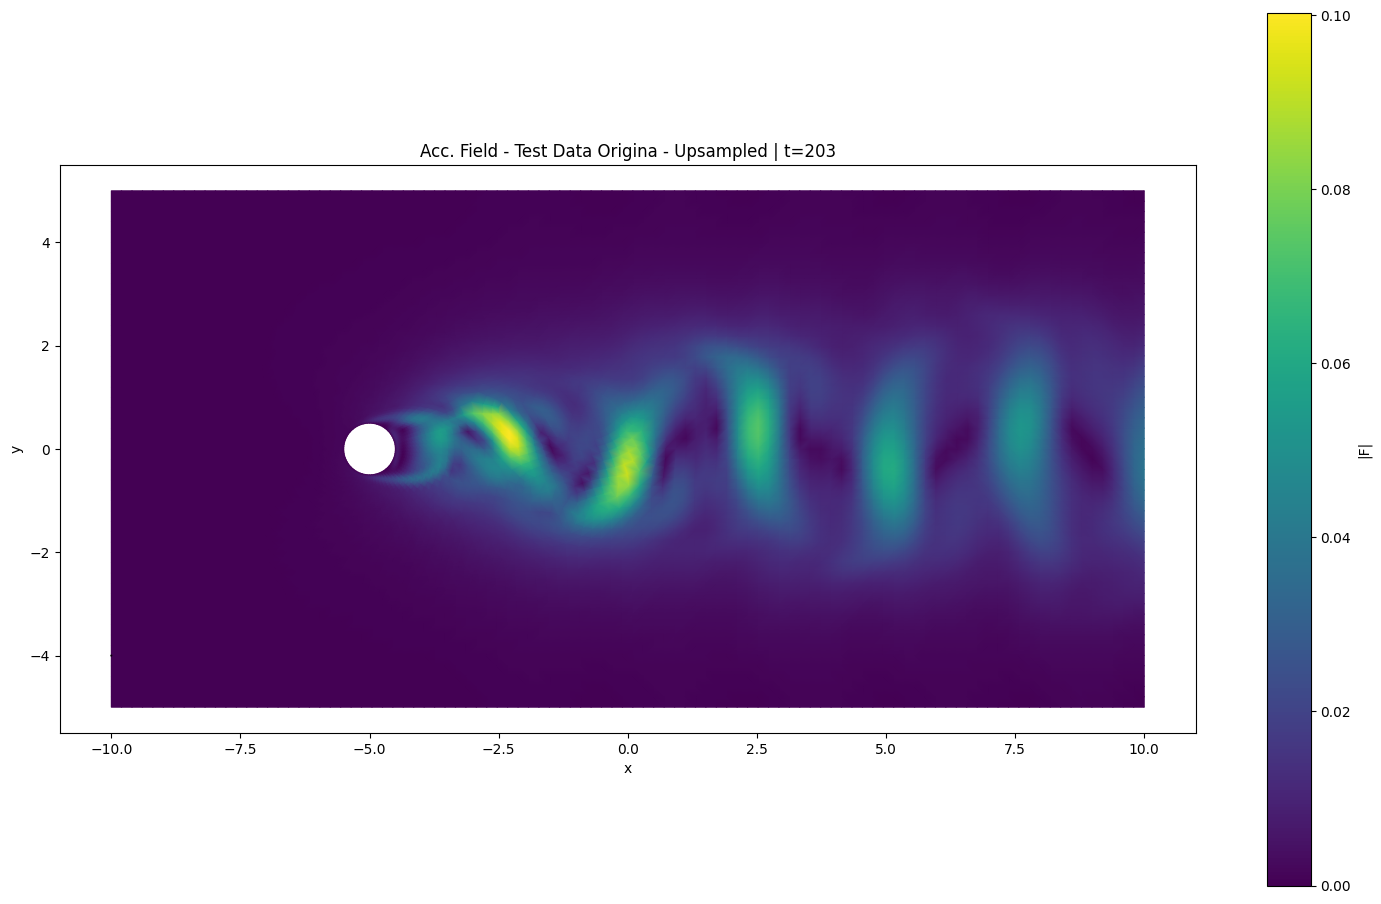

In [31]:
dv_x_test = DX_test[0:6569,:]
dv_y_test = DX_test[6569:13138,:]
plot_vector_field(dv_x_test,dv_y_test,coordx,coordy, train_path, name = 'Acc. Field - Test Data Origina - Upsampled', t_index=203,  quiver_frac=0.0)

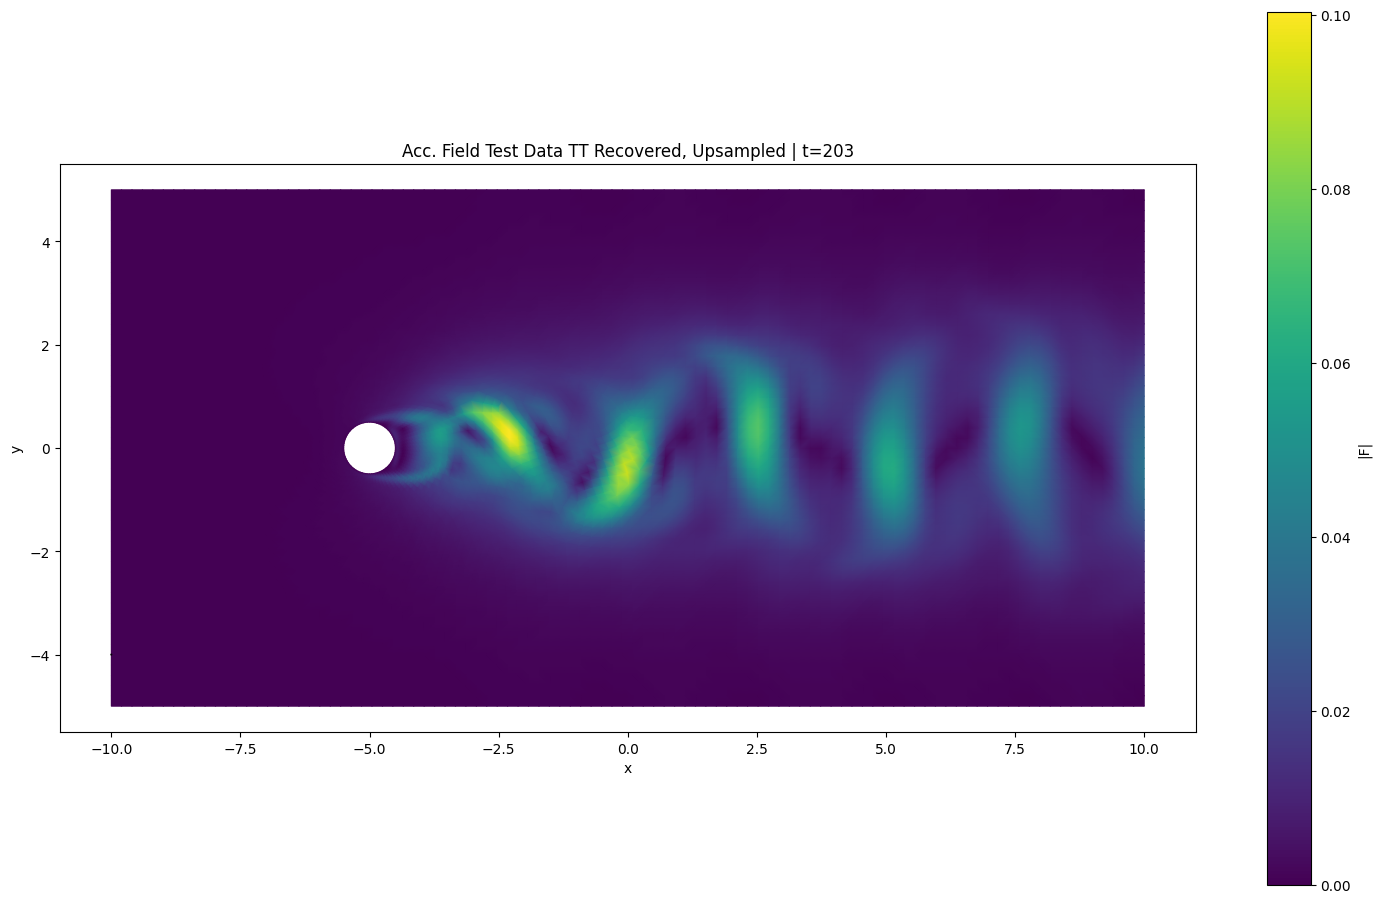

In [32]:
dv_x_hat_test = DX_test_hat[0:6569,:]
dv_y_hat_test = DX_test_hat[6569:13138,:]
plot_vector_field(dv_x_hat_test,dv_y_hat_test,coordx,coordy, train_path, name = 'Acc. Field Test Data TT Recovered, Upsampled', t_index=203,  quiver_frac=0.0)

In [33]:
def l2_error(DXrav_hat_list, DXrav_test):
    err_arr = []
    for i in range(len(DXrav_hat_list)):
        l2_err = 100 * np.linalg.norm( Ur @ DXrav_hat_list[i] -  Ur @ DXrav_test, axis = 0)/np.linalg.norm( Ur @ DXrav_test, axis = 0)
        err_arr.append(l2_err)
    return err_arr

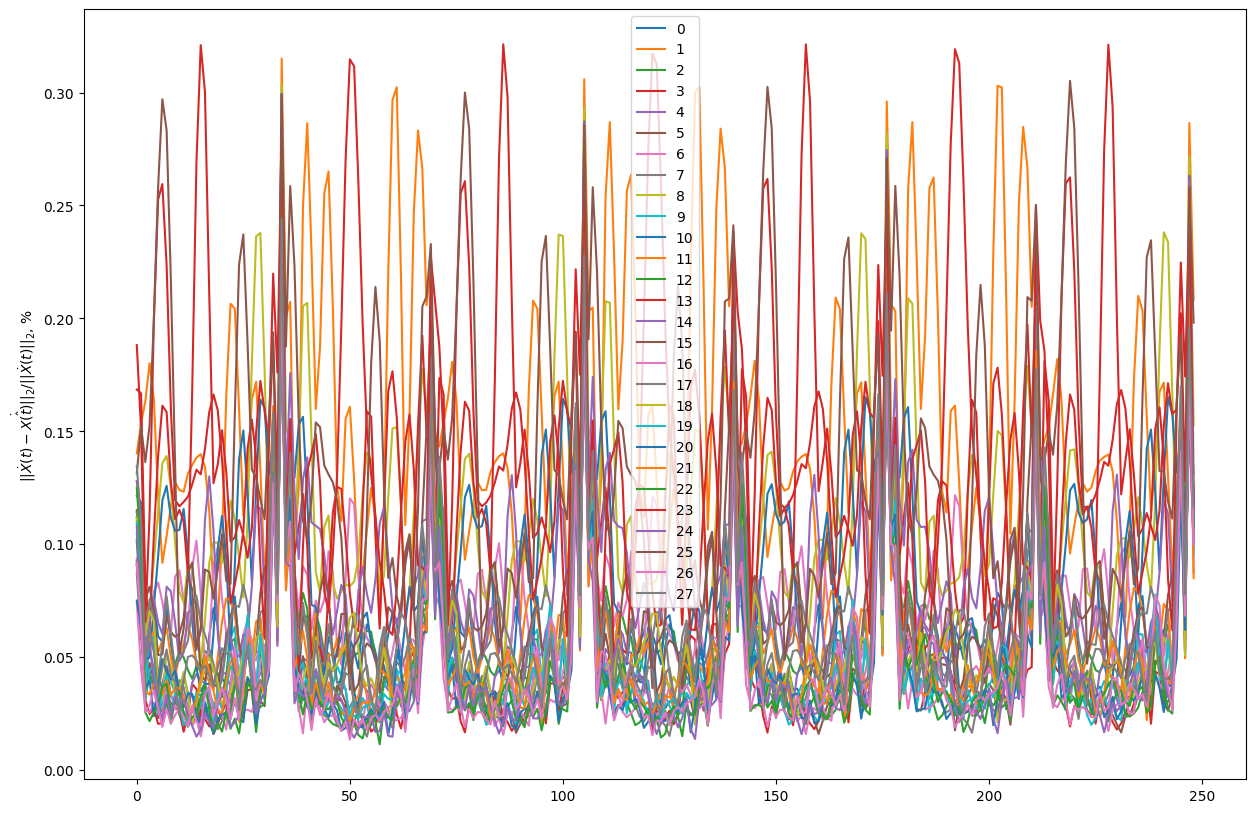

In [34]:
#Check the L2 norm:
plt.figure(figsize=(15, 10))
err_arr = l2_error(DXrav_hat_list, DXrav_test)
for i in range(len(DXrav_hat_list)):
    plt.plot(err_arr[i], label = f'{i}')
    plt.ylabel(r'$||\dot{X}(t) -\dot{\hat{X(t)}}||_{2}/ ||\dot{X}(t)||_{2}$, %')
    plt.legend()
plt.show()

In [35]:
###################################
# Integrating the result:
X0_test = np.expand_dims(Xrav_test[:,0], axis = 1)
# Use all trained models for ensemble integration by averaging their predictions
Xr_mean = np.mean(Xr,axis = 1, keepdims=True)
Vhat_upsampled = np.zeros(shape=(Ur.shape[0], Xrav_test.shape[1] - 1))
X_testing = X0_test

for i in tqdm(range(Xrav_test.shape[1] - 1)):
    _measures = build_measures(X_testing.T, degree = degree)
    _augmented_test_measures = np.concatenate(
        [_measures, np.ones((1, X_testing.shape[1], degree+1))],
        axis=0
    )
    # Rewritten using list comprehension and numpy.mean
    # This calculates the evaluation for each model and then averages them element-wise
    res = np.mean([model.evaluate(_augmented_test_measures) for model in trained_tensors], axis=0)

    Vhat_upsampled[:,i] = Ur @ (res.T + X_testing)[:,0]
    X_testing = res.T + X_testing

  0%|          | 0/249 [00:00<?, ?it/s]

In [36]:
Xrav_test.shape,X0_test.shape, Ur.shape, res.T.shape, X_testing.shape, Xr_mean.shape

((25, 250), (25, 1), (13138, 25), (25, 1), (25, 1), (25, 1))

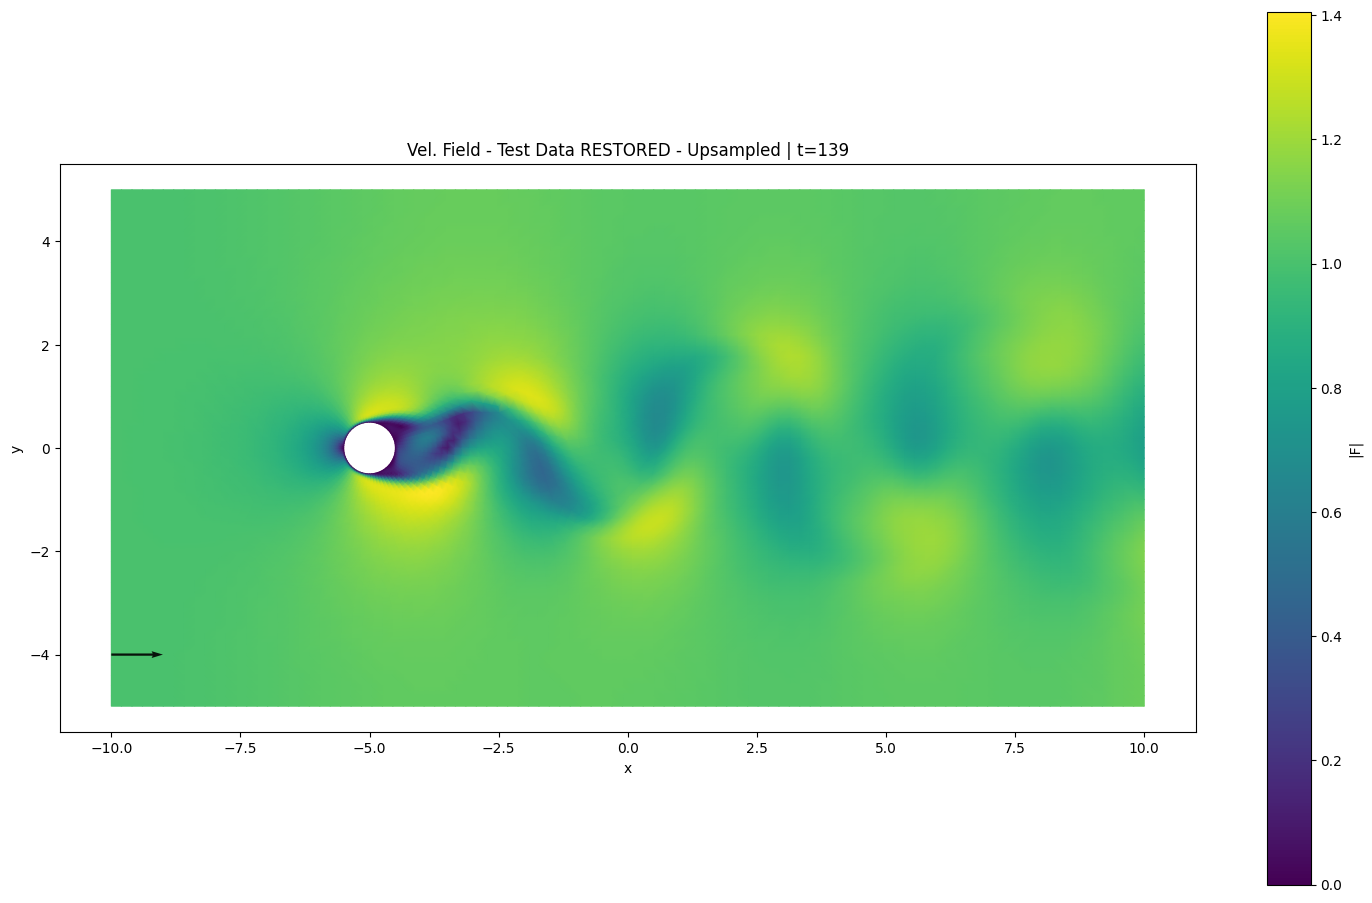

In [37]:

# We must restore mean here!
Vhat_upsampled_with_mean = Vhat_upsampled + np.mean(V, axis = 1, keepdims=True)
v_x_hat_test = Vhat_upsampled_with_mean[0:6569,:]
v_y_hat_test = Vhat_upsampled_with_mean[6569:13138,:]
plot_vector_field(v_x_hat_test,v_y_hat_test,coordx,coordy, train_path,  name = 'Vel. Field - Test Data RESTORED - Upsampled', t_index=139,  quiver_frac=0.0)

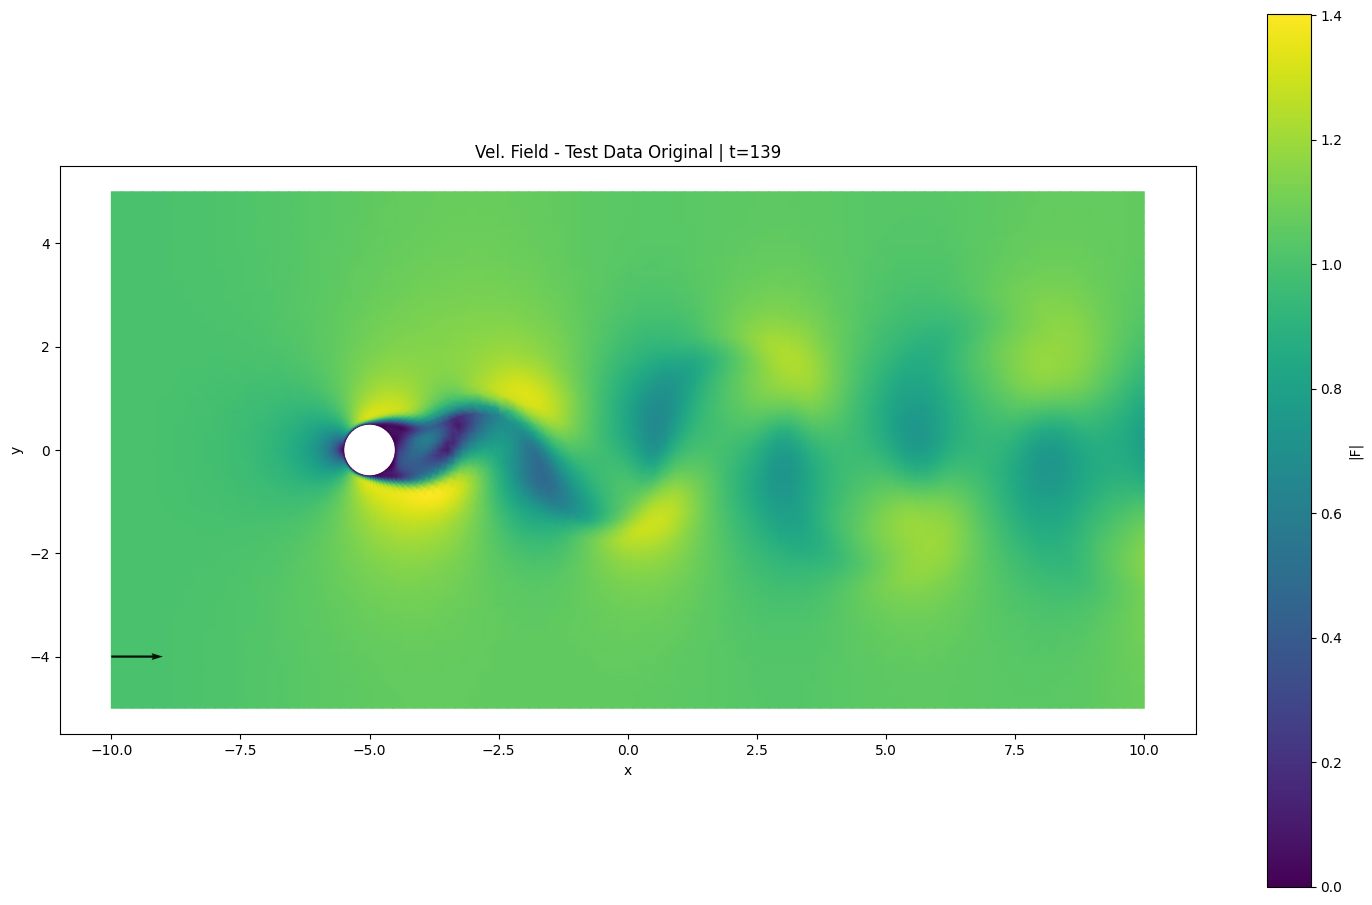

In [38]:

V_test_demean = V_test[:,1:]
v_x_test_orig = V_test_demean[0:6569,:]
v_y_test_orig = V_test_demean[6569:13138,:]
plot_vector_field(v_x_test_orig,v_y_test_orig,coordx,coordy, train_path, name = 'Vel. Field - Test Data Original', t_index=139,  quiver_frac=0.0)

In [39]:
dmd_error = np.load(os.path.join(OUT_DIR  + f"DMD_rollout_error1.npz") + ".npy")

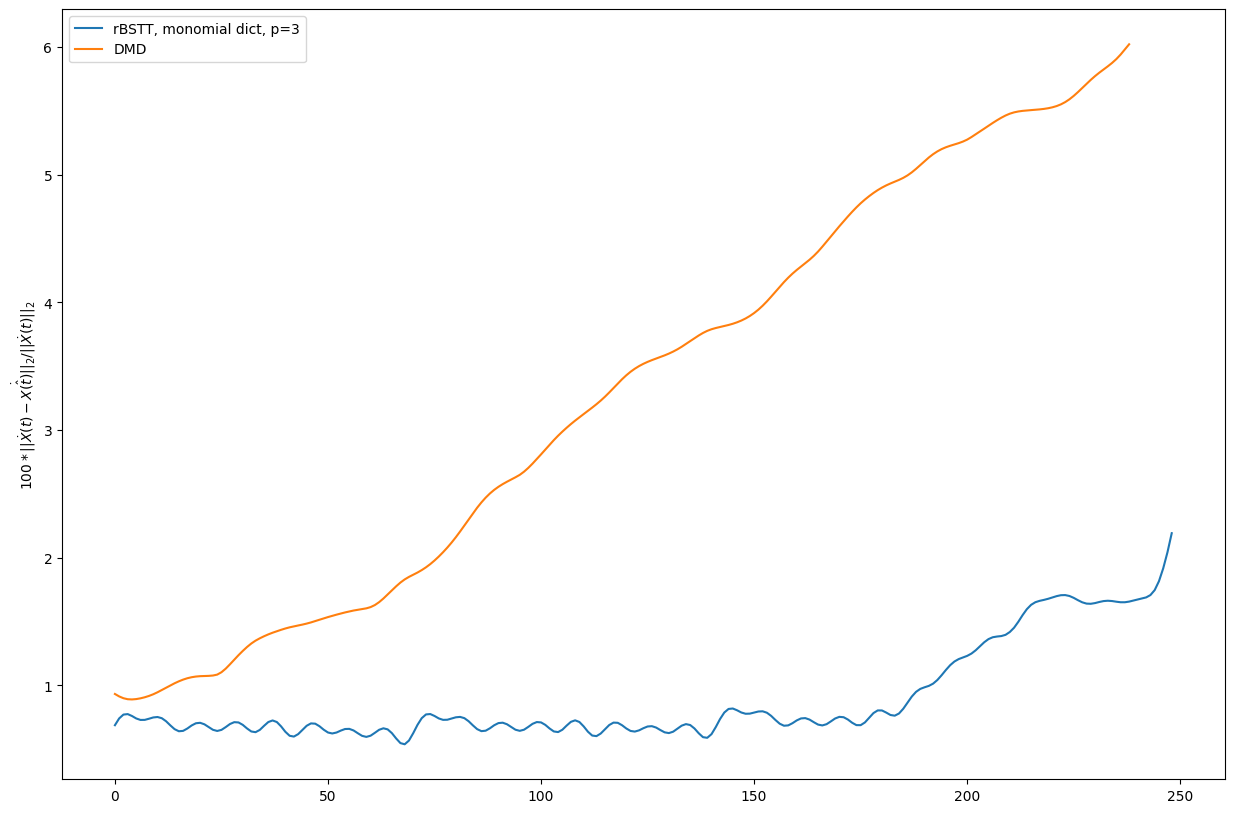

In [42]:
#Check the L2 norm:
max_idx =250
L2_diff_pointwise = 100 * np.linalg.norm(V_test_demean[:,0:max_idx] -  Vhat_upsampled_with_mean[:,0:max_idx], axis = 0)/np.linalg.norm( V_test_demean[:,0:max_idx], axis = 0) # It seems the difference is less then 1%
plt.figure(figsize=(15, 10))
plt.plot(L2_diff_pointwise, label = r'rBSTT, monomial dict, p=3')
plt.plot(dmd_error[:max_idx], label = r'DMD')
#plt.ylim(0,100)
plt.ylabel(r'$ 100 * ||\dot{X}(t) -\dot{\hat{X(t)}}||_{2}/ ||\dot{X}(t)||_{2}$')
plt.legend()
plt.show()

In [41]:
V_test_demean.shape

(13138, 249)